## Influence of `batch_size`
- Simulations in JAX-MD are dispatched to XLA to asynchronously run on accelerators.
- However, certain cases require that we periodically return to Python to perform other tasks, e.g. checking for
  neighbor list overflows or persisting intermediate results.
- Let's call the number of MD steps that are dispatched to XLA in one chunk `batch_size`.
- `steps = 1000`, `batch_size = 5`
  - We perform 1000 MD steps total
  - We dispatch these to XLA in chunks of 5 steps at a time:
    ```
    i = 0
    while i < 1000:
        state, neighbors = lax.fori_loop(0, 5, step_fn, (state, neighbors))

        # do some work: check for NL overflows & recompute
        if neighbors.did_buffer_overflow:
            neighbors = neighbor_fn(state.position)
            continue

        i += 5
    ```

- `batch_size` seems to be a sensible hyperparameter for MD simulations.
- Hypothesis: Every context change between XLA and Python is expensive. Thus, batch_size should be a performance-critical hyperparameter.
  1. Larger values of `batch_size` should increase performance as it lowers the number of (slow) context switches
     between Python and XLA.
  2. However, it also implies less frequent checks for neighbor list overflows. This enlarges the amount of time
     during which an overflow can go unnoticed, potentially distorting results.

The following cells implement a NVE simulation on Lennard-Jones Argon to investigate hypothesis i. We will initialize systems of fixed size while continuously increasing values for `batch_size`.

### Some imports

In [7]:
import os, sys
cwd = os.path.abspath('')
root_dir = os.path.dirname(cwd)
if not root_dir in sys.path: sys.path.append(root_dir)

In [8]:
import time
from typing import List
import jax.config
import numpy as np
from ase import units
from jax import jit, lax
from jax_md import space, energy, simulate
from jax_md.simulate import NVEState
jax.config.update("jax_enable_x64", True)

import jax_utils
from ase.atoms import Atoms
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt

### Initialization

In [9]:
def initialize_cubic_argon(multiplier=5, temperature_K: int = 30) -> Atoms:
    atoms = bulk("Ar", cubic=True) * [multiplier, multiplier, multiplier]
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature_K)
    Stationary(atoms)
    atoms.calc = LennardJones(sigma=sigma, epsilon=epsilon, rc=rc, ro=ro, smooth=True)
    return atoms

sigma = 2.0
epsilon = 1.5
rc = 10.0
ro = 6.0
dt = 5 * units.fs

atoms = initialize_cubic_argon(multiplier=10)
print("Initialized cubic Argon, n = {}".format(len(atoms)))

Initialized cubic Argon, n = 4000


### Some helpers for benchmarking & ASE initialization

In [10]:
def get_initial_nve_state(atoms: Atoms) -> NVEState:
    R = atoms.get_positions(wrap=True)
    V = atoms.get_velocities()
    forces = atoms.get_forces()
    masses = atoms.get_masses()[0]
    return NVEState(R, V, forces, masses)

def get_milliseconds(start_time: float) -> float:
    return round((time.monotonic() - start_time) * 1000, 2)

def get_mean_step_time(batch_times: List[float], batch_size: int) -> float:
    return round(np.mean([bt/batch_size for bt in batch_times]), 2)

### NVE simulation routine

In [11]:
def run_nve(atoms: Atoms, steps: int, batch_size: int):

    @jit
    def step_fn(i, state):
        state, neighbors = state
        neighbors = neighbor_fn(state.position, neighbors)
        state = apply_fn(state, neighbor=neighbors)
        return state, neighbors

    batch_times = []

    # setup displacement
    box = atoms.get_cell().array
    displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=False)

    # normalize LJ parameters and setup NL energy function
    normalized_ro = ro / sigma
    normalized_rc = rc / sigma
    neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement_fn, box,
                                                                sigma=sigma,
                                                                epsilon=epsilon,
                                                                r_onset=normalized_ro,
                                                                r_cutoff=normalized_rc,
                                                                dr_threshold=1 * units.Angstrom)
    energy_fn = jit(energy_fn)

    # compute initial neighbor list
    R = atoms.get_positions(wrap=True)
    neighbors = neighbor_fn(R, extra_capacity=100)

    # compute initial state & setup NVE
    state = get_initial_nve_state(atoms)
    _, apply_fn = simulate.nve(energy_fn, shift_fn, dt=dt)

    # run MD loop
    i = 0
    while i < steps:
        batch_start_time = time.monotonic()
        state, neighbors = lax.fori_loop(0, batch_size, step_fn, (state, neighbors))

        if neighbors.did_buffer_overflow:
            neighbors = neighbor_fn(state.position)
            print("Steps {}/{}: Neighbor list overflow, recomputing...".format(i, steps))
            continue

        batch_times += [get_milliseconds(batch_start_time)]
        i += batch_size

    return get_mean_step_time(batch_times, batch_size)

### Actual benchmark

Let's run NVE simulations with `steps = 5000` and different `batch_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]`.

In [12]:
batch_sizes = list(range(100, 2100, 100))
step_times = []

for bs in batch_sizes:
    atoms = initialize_cubic_argon(multiplier=10)

    mean_step_time = run_nve(atoms, steps=5000, batch_size=bs)
    step_times += [mean_step_time]
    print("n = {:<5} \t\t batch_size = {:<4} \t\t average ms/step = {}".format(len(atoms), bs, mean_step_time))

n = 4000  		 batch_size = 100  		 average ms/step = 33.21
n = 4000  		 batch_size = 200  		 average ms/step = 33.2
n = 4000  		 batch_size = 300  		 average ms/step = 33.21
n = 4000  		 batch_size = 400  		 average ms/step = 33.24
n = 4000  		 batch_size = 500  		 average ms/step = 33.2
n = 4000  		 batch_size = 600  		 average ms/step = 33.23
n = 4000  		 batch_size = 700  		 average ms/step = 33.21
Steps 4800/5000: Neighbor list overflow, recomputing...
n = 4000  		 batch_size = 800  		 average ms/step = 33.39
n = 4000  		 batch_size = 900  		 average ms/step = 33.22
n = 4000  		 batch_size = 1000 		 average ms/step = 33.22
Steps 4400/5000: Neighbor list overflow, recomputing...
n = 4000  		 batch_size = 1100 		 average ms/step = 33.5
n = 4000  		 batch_size = 1200 		 average ms/step = 33.22
n = 4000  		 batch_size = 1300 		 average ms/step = 33.24
n = 4000  		 batch_size = 1400 		 average ms/step = 33.23
n = 4000  		 batch_size = 1500 		 average ms/step = 33.23
n = 4000  		 batch_si

### Results

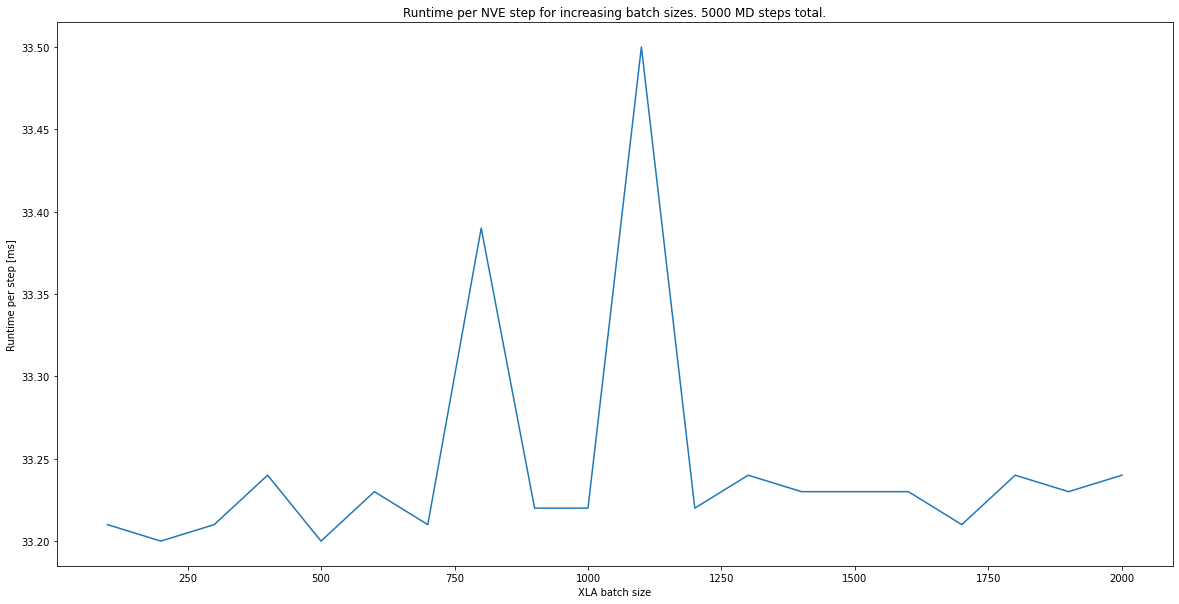

In [17]:
plt.figure(figsize=(20, 10))
plt.title("Runtime per NVE step for increasing batch sizes. 5000 MD steps total.")
plt.xlabel("XLA batch size")
plt.ylabel("Runtime per step [ms]")
plt.plot(batch_sizes, step_times)

- The average runtime per step seems to be largely unaffected by the value of `batch_size`.
- Why is this?